# Copernicus Data Access

### Import Libraries

In [1]:
import ee
import geemap
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
from urllib.request import urlopen
import ipywidgets as widgets
import lxml

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Administrator\anaconda3\envs\copernicus\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## 1 - Copernicus Marine Service (CMEMS) data from OPeNDAP API

Reference material for this Copernicus Marine data can be found here:
- https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python
- https://www.youtube.com/watch?v=ZJoRZYiMQcM&ab_channel=CopernicusMarineService

First of all define a function able to retrieve the data from Copernicus Marine API, using OPeNDAP. The data used for this example can be accessed from [here](https://resources.marine.copernicus.eu/product-detail/MEDSEA_ANALYSISFORECAST_PHY_006_013/DATA-ACCESS):

In [ ]:
# #! /usr/bin/env python3
# # -*- coding: utf-8 -*-
# __author__ = "Copernicus Marine User Support Team"
# __copyright__ = "(C) 2022 E.U. Copernicus Marine Service Information"
# __credits__ = ["E.U. Copernicus Marine Service Information"]
# __license__ = "MIT License - You must cite this source"
# __version__ = "202104"
# __maintainer__ = "D. Bazin, E. DiMedio, C. Giordan"
# __email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"

def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session)) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session)) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

The **id** and **password** are the same used for logging in the Copernicus Marine website.

In [ ]:
username = widgets.Text(
    placeholder='Copernicus Marine Username',
    description='Username:',
    disabled=False)
username

In [ ]:
password = widgets.widgets.Password(
    placeholder='Enter password',
    description='Copernicus Marine Password:',
    disabled=False,)
password

In [ ]:
# Required the data using the function copernicusmarine_datastore
data_store = copernicusmarine_datastore('med-cmcc-tem-an-fc-d', username.value, password.value)

The data_store variable can be open with xarray library, using the open_dataset function:

In [ ]:
DS = xr.open_dataset(data_store).sel(time='2021-01-01', method='nearest')
DS

Is possible to slice the xarray dataset using lat/lon and creating a cropped dataset over the area of interest:

In [ ]:
min_lon = 12
min_lat = 40 
max_lon = 19
max_lat = 46 


cropped_ds = DS.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_ds

The dataset can be plotted or used for further analysis:

In [ ]:
temp_mod = cropped_ds['thetao'].sel(depth=0,method='nearest').squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([11,20, 39, 46],crs=ccrs.PlateCarree())

f.suptitle('Adriatic Sea surface temperature', fontsize=28)
im = ax.pcolor(temp_mod['lon'].data,temp_mod['lat'].data, temp_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('°C', rotation =270, fontsize=23,labelpad=15)

----

## 2- Copernicus Atmosphere Monitoring Service (CAMS) data using cdsapi library

Reference: https://github.com/ecmwf/cdsapi/issues/25

Remeber to use the key to access CAMS API. It can be retrieved as explained at this link: https://ads.atmosphere.copernicus.eu/api-how-to.

In [ ]:
ads_api_key = widgets.Text(
    placeholder='ADS API KEY',
    description='Key:',
    disabled=False)
ads_api_key

In [ ]:
c = cdsapi.Client("https://ads.atmosphere.copernicus.eu/api/v2", ads_api_key.value) #change ads_key

It is possible to define the download parameters using the tab form provided by CAMS (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=form) and pass them to the **retrive** function of the cdsapi library.

In [ ]:
# API request
params = {'format': 'netcdf',
        'variable': 'particulate_matter_2.5um',
        'model': 'ensemble',
        'date': '2022-04-18/2022-04-20',
        'level': '0',
        'type': 'analysis',
        'time':'00:00',
        'leadtime_hour': 0,
        'area': [48,6, 43, 13]}

# retrieve the location of the file
fl = c.retrieve('cams-europe-air-quality-forecasts', params) 

# load into memory 
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read()).mean(dim='time')

In [ ]:
ds

The CAMS dataset can be plotted as follow:

In [ ]:
pm_mod = ds['pm2p5_conc'].squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
#ax.set_extent([5,14, 42, 49],crs=ccrs.PlateCarree())

f.suptitle('Po Valley PM2.5', fontsize=28)
im = ax.pcolor(pm_mod['longitude'].data,pm_mod['latitude'].data, pm_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('µg/m3', rotation =270, fontsize=23,labelpad=15)

----

## 3 - Copernicus Emergency Management Service (CEMS) data using cdsapi library

Remember to use the key from C3S: https://cds.climate.copernicus.eu/api-how-to

In [ ]:
# cds_api_key = widgets.Text(
#     placeholder='ADS API KEY',
#     description='Key:',
#     disabled=False)
# cds_api_key

In [ ]:
# c = cdsapi.Client("https://cds.climate.copernicus.eu/api/v2", cds_api_key.value) #change ads_key

In [ ]:
# # API request
# params = {
#         'variable': 'river_discharge_in_the_last_24_hours',
#         'format': 'netcdf',
#         'leadtime_hour': '24',
#         'day': '01',
#         'month': '01',
#         'year': '2022',
#         'hydrological_model': 'lisflood',
#         'product_type': 'control_forecast',
#         'system_version': 'operational',
#         'area': [48,5,35,20]
#     }
# # retrieve the location of the file
# fl = c.retrieve('efas-historical', params) 

# # load into memory 
# with urlopen(fl.location) as f:
#     ds = xr.open_dataset(f.read()).mean(dim='time')

In [5]:
ds = xr.open_dataset('efas.nc')

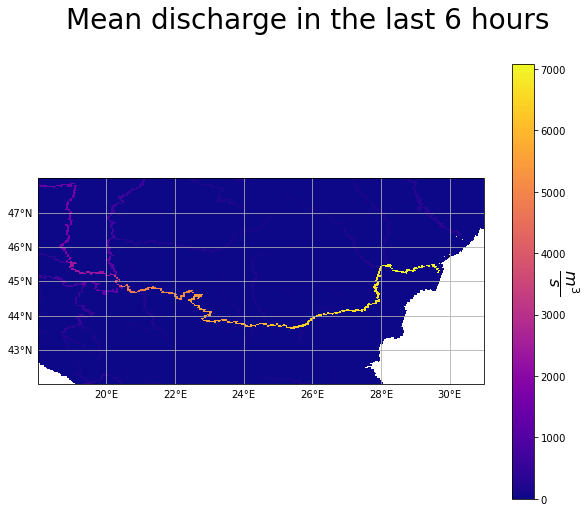

In [18]:
# Must check variables names and change this accordingly
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([18, 31, 42, 48],crs=ccrs.PlateCarree())

f.suptitle('Mean discharge in the last 6 hours', fontsize=28)
im = ax.pcolor(ds['longitude'].data,ds['latitude'].data, ds.variables['dis06'][:], cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label(r'$\frac{m^{3}}{s}$', rotation =270, fontsize=23,labelpad=15)

----

## 4 - ERA5 - Copernicus Climate Change Service (C3S) Data from Google Earth Engine

To access Google Earth Engine is necessary to have a Google account. Then is possible to Authenticate and Inizialize the session:

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize()

An equivalent procedure can be followed for [ERA5 data](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY?hl=en) available on Google Earth Engine Catalog. First we show a map:

In [ ]:
Map_era5 = geemap.Map(center=[45.5,10], zoom = 5 )
Map_era5

In [ ]:
# Daily mean 2m air temperature
temp_2m = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                   .select('temperature_2m')\
                   .filter(ee.Filter.date('2021-07-02'))

temp_2m_clip = temp_2m.mean()

In [ ]:
# Visualization palette for mean temperature at 2m
import geemap.colormaps as cm
palette = cm.get_palette('coolwarm', n_class=8)
cm.plot_colormap('coolwarm', width=8.0, height=0.4, orientation='horizontal')
temp_2m_viz  = {
  'min': 280,
  'max': 300,
  'palette': palette
};

In [ ]:
Map_era5.addLayer(temp_2m_clip, temp_2m_viz, '2m temperature');
Map_era5.add_colorbar(temp_2m_viz, label="°C", layer_name="°C")

----

## 5 - Copernicus Land Monitoring Service (CLMS) from Google Earth Engine

As a first step it is possible to create a map and show the data:

In [ ]:
#Create a map
Map= geemap.Map(center=[44,10], zoom = 5 )
Map

In this example Copernicus Land Cover data are used. The dataset can be accessed from [here](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global).

In [ ]:
#Access Copernicus Land Cover classification 2019
lc = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019')\
    .select('discrete_classification')

Then a region of interest can be selected and used for clipping the data:

In [ ]:
#Clip over the ROI previously defined
roi = ee.Geometry.BBox(3, 35, 20, 50)
lc_clip = lc.clip(roi)
Map.addLayer(lc_clip, {}, 'Land Cover');
Map.add_legend(builtin_legend='COPERNICUS/Landcover/100m/Proba-V/Global')

In [ ]:
# #To get information about the data
# props = geemap.image_props(lc)
# props.getInfo()